In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from src.model import ToyNN
from src.generate_data import generate_batch
from src.vis import draw_mini_plots

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Задание

Воспроизвести статью [Antropic](https://transformer-circuits.pub/2023/toy-double-descent/index.html) о двойном спуске и суперпозиции.

Кратко:
- Изначально модель работает в режиме запоминания. Она запоминает высокоразмерные данные в виде отдельных точек в состоянии суперпозиции. В этом случае мы получаем маленький лосс на трейне и большой на тесте.
- С другой стороны модель может работать в режиме обобщения. В этом случае модель обобщает признаки водит их в состоянии суперпозиции. В этом случае имеем низкий лосс как на трейне так и на тесте.
- Между режимами запомпинания (мемоизации) и обобщения (генерализации) происходит скачок значения лосса, который и определяет границу перехода между ними.

Предлагается реализовать игрушечную модель (см. `/src/model.py`)

В статье утверждается, что модель должна находиться в режиме мемоизации в случае, когда размер обучающего набора меньше количества признаков, и в режиме генерализации, когда размер набора больше числа признаков.

### Параметры эксперимента

На вход модели подаются векторы признаков размерностью $n=10000$, отдельным признакам значения проставляются в вероятностью $S=0.001$, $\vert\vert x \vert\vert = 1$

#### Параметры обучения

В качестве оптимизатора берется $AdamW$, с величиной регуляризации $l_{2 reg}=10^{-2}$. Количество шагов обучения $50000$. Прогрев занимает $2500$ шагов $lr \in [0, 10^{-3}]$, затем по косинусу убывает до $0$. На каждом шаге обучения используется весь заготовленный батч с данными.


Визуализация признаков и скрытых состояний при условии малых данных

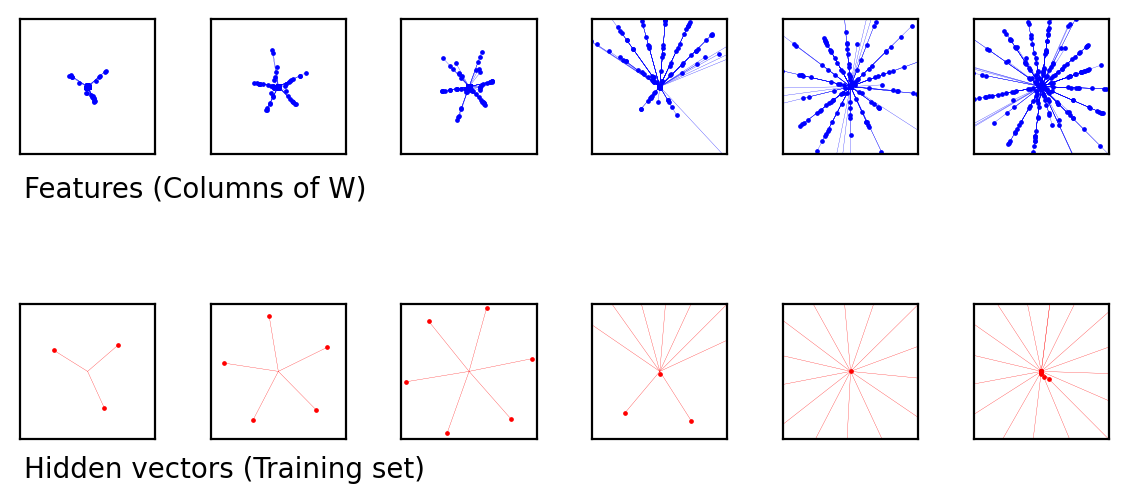

In [3]:
fig, _ = draw_mini_plots([3, 5, 6, 10, 15, 30])

fig.text(0.05, 0.55, 'Features (Columns of W)', va='center', rotation='horizontal')
fig.text(0.05, 0.20, 'Hidden vectors (Training set)', va='center', rotation='horizontal')

plt.show()

Признаки

### Размерность признака

Размерность обучающего примера с данными

$D_{X_i} = \frac{\vert\vert h_{i} \vert\vert^{2}}{\sum_{j}(\hat{h}_{i}\cdot h_{j})^2}$

In [2]:
T = [3, 5, 6, 10, 15, 30, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]

weights_dict = {}
train_hiddens_dict = {}
test_losses_dict = {}
test_hiddens_dict = {}
criterion = nn.MSELoss()

for i, t in tqdm(enumerate(T)):

    test_losses = []
    test_hiddens = []

    checkpoint = torch.load(f'../checkpoints/checkpoint_{t}.pth', weights_only=False)
    model = ToyNN(input_dim=10_000, hidden_dim=2)
    model.load_state_dict(checkpoint['model'])

    test_batch = generate_batch(
        n_batch=1000,
        n_features=10_000,
        sparsity_prob=0.999,
    )

    model.eval()
    with torch.inference_mode():
        output, hiddens = model(test_batch)
        test_loss = criterion(output, test_batch)
        test_losses.append(test_loss.item())
        test_hiddens.append(hiddens)

    test_losses_dict[t] = test_losses
    test_hiddens_dict[t] = test_hiddens
    weights_dict[t] = model.W.detach().cpu().numpy()
    train_hiddens_dict[t] = checkpoint['hiddens']

16it [00:01, 13.87it/s]


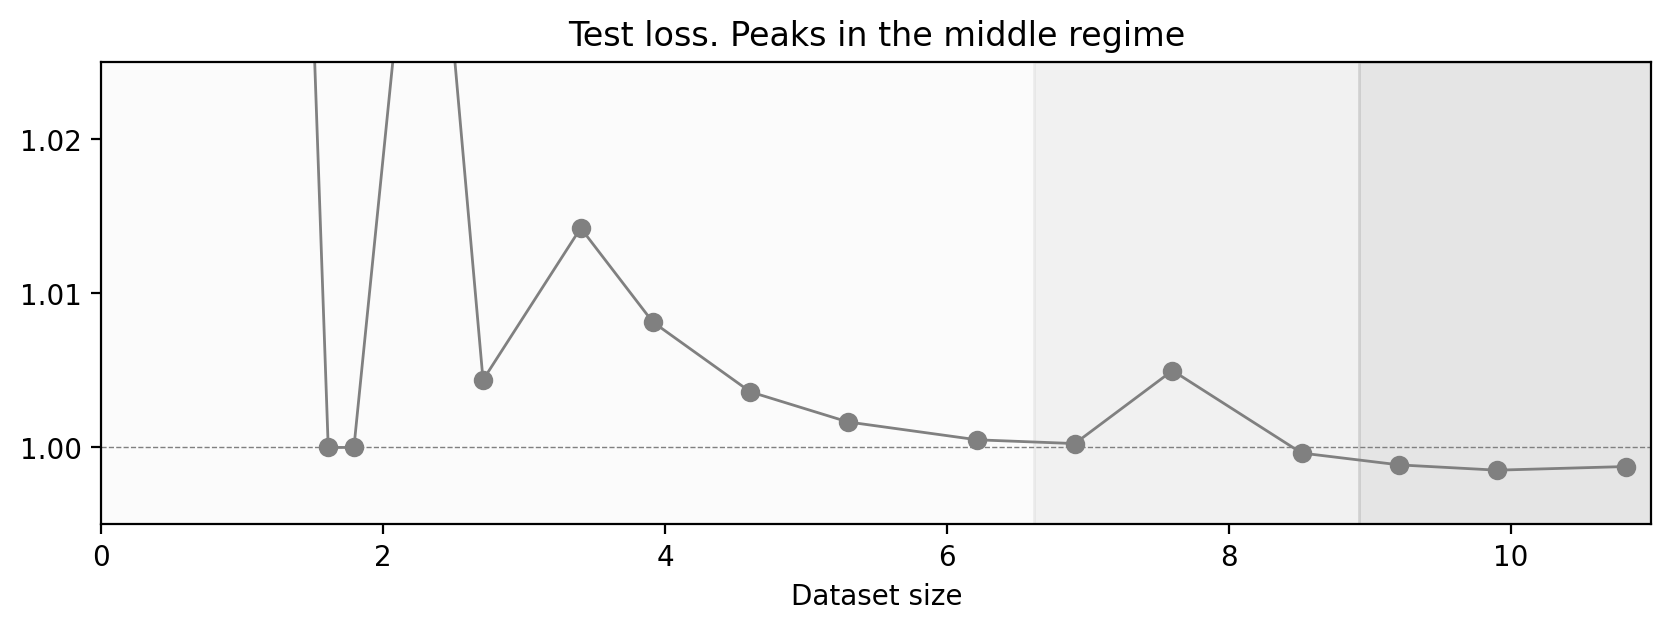

In [3]:
plt.figure(figsize=(10, 3))
plt.plot(np.log(T), np.array([value[0] for value in test_losses_dict.values()]) * 10_000, marker='o', linewidth=1, color='gray')

plt.yticks([1.0, 1.01, 1.02])
plt.ylim([0.995, 1.025])
plt.xlim([0, 11])
plt.xlabel("Dataset size")
plt.title("Test loss. Peaks in the middle regime")

plt.axvspan(0, np.log(750), color='whitesmoke', alpha=0.3, label='Small Dataset')
plt.axvspan(np.log(750), np.log(7500), color='lightgray', alpha=0.3, label='Small Dataset')
plt.axvspan(np.log(7500), np.log(110000), color='darkgray', alpha=0.3, label='Memorizing regime')

plt.axhline(y=1, color='grey', linestyle='--', linewidth=0.5)

plt.show()

In [94]:

w_dims_dict = {}
for t, W in tqdm(weights_dict.items()):
    w_dims_dict[t] = ToyNN.dimensionality(torch.tensor(W, dtype=torch.float32)).numpy()


hidden_dims = {}
for t, hidden in train_hiddens_dict.items():
    hidden_tensor = torch.tensor(hidden, dtype=torch.float32)
    hidden_dims[t] = (ToyNN.dimensionality(hidden_tensor).numpy())

100%|██████████| 16/16 [00:00<00:00, 22.81it/s]


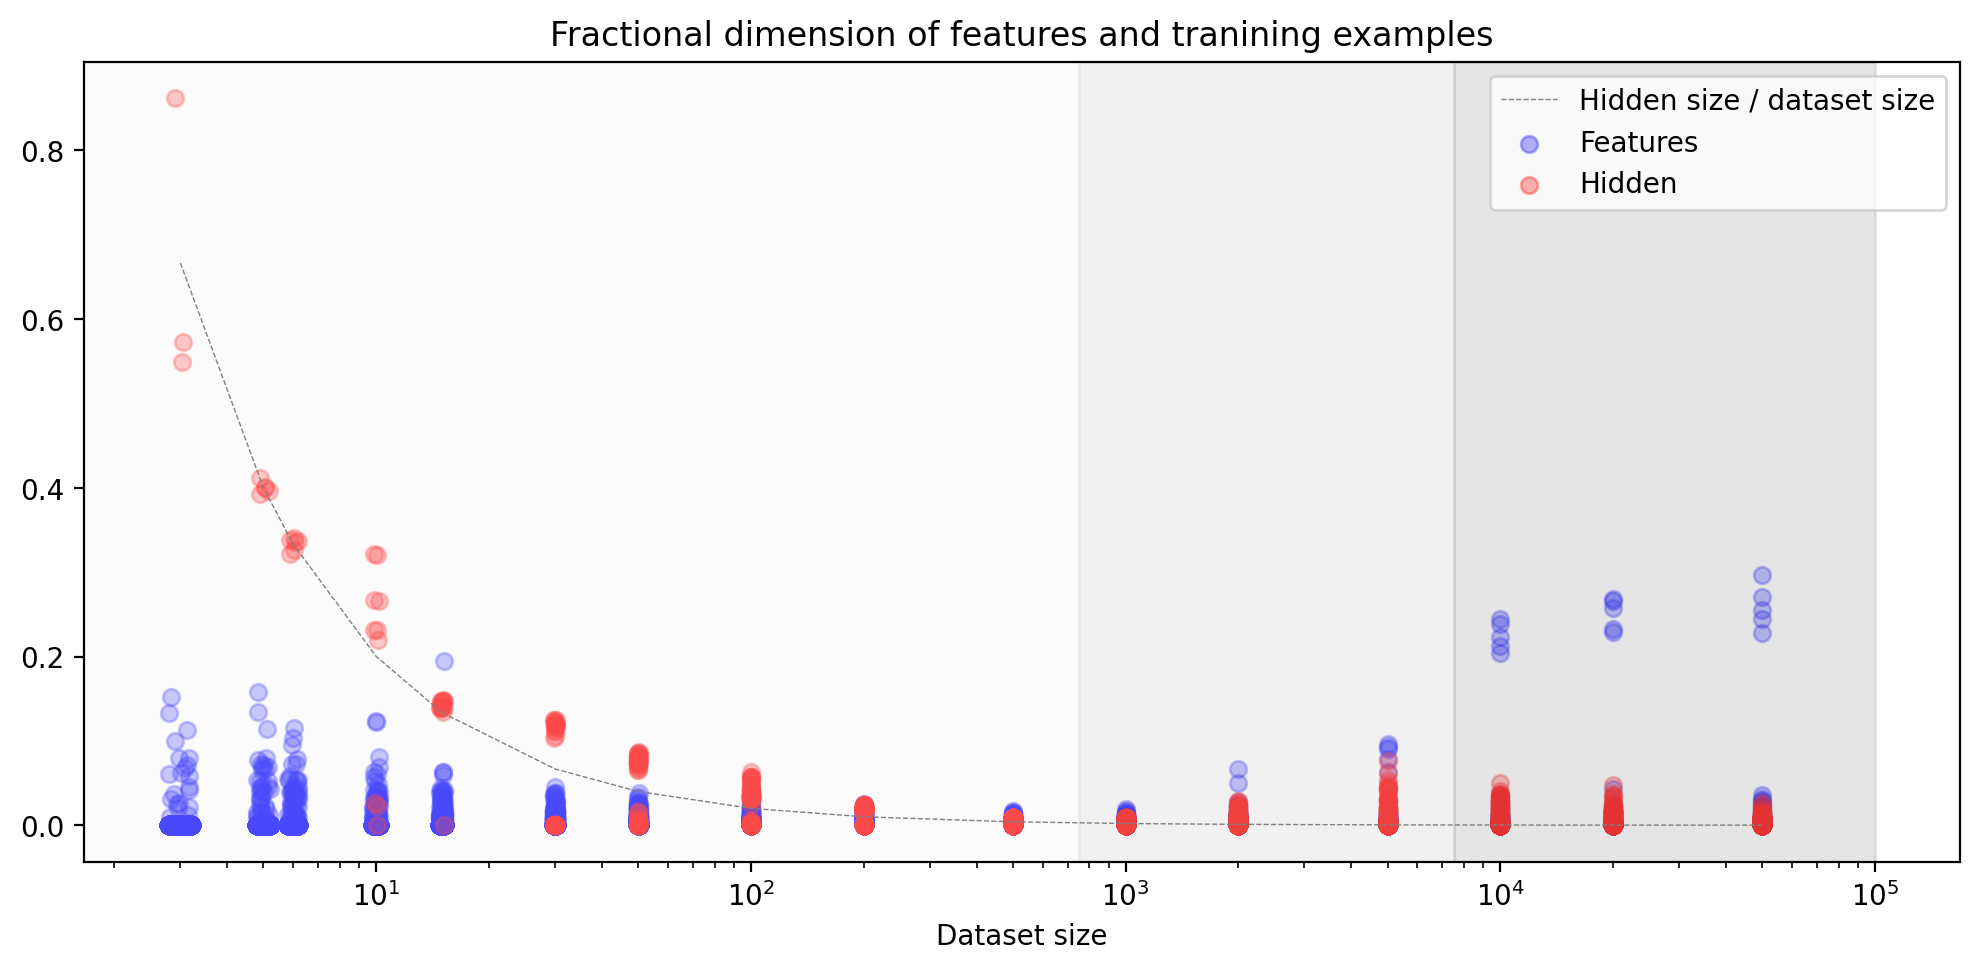

In [111]:
import random

T = [3, 5, 6, 10, 15, 30, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]

point_deviations = [random.uniform(-0.2, 0.2) for _ in range(max(10_000, max(T)))]
point_deviations = np.array(point_deviations)

plt.figure(figsize=(10, 5))

plt.plot(T, [2 / t for t in T], linestyle='--', linewidth=0.5, color='gray', label='Hidden size / dataset size')

for t in T:
    points = point_deviations[0: 10_000] + t
    plt.scatter(points, w_dims_dict[t], color='blue', alpha=0.3, label="Features" if t == min(T) else "")
    points = point_deviations[0: t] + t
    plt.scatter(points, hidden_dims[t], color='red', alpha=0.3, label="Hidden" if t == min(T) else "")

plt.axvspan(0, 750, color='whitesmoke', alpha=0.3)
plt.axvspan(750, 7500, color='lightgray', alpha=0.3)
plt.axvspan(7500, 100000, color='darkgray', alpha=0.3)

plt.legend()
plt.title("Fractional dimension of features and tranining examples")
plt.xlabel('Dataset size')
plt.xscale('log')
plt.tight_layout()
plt.show()

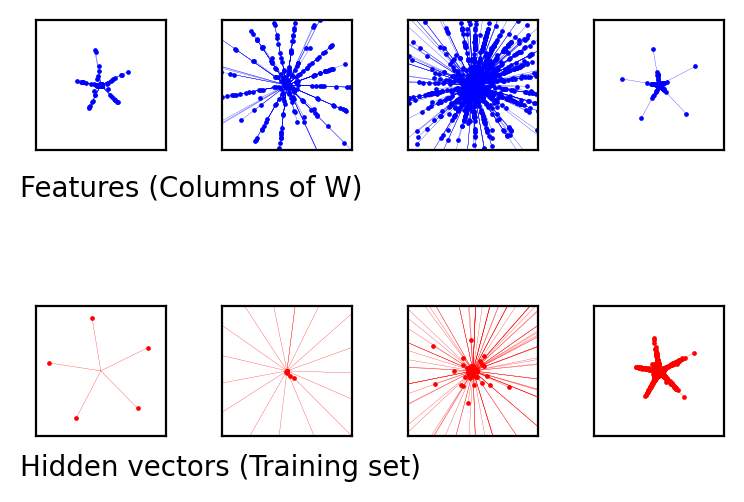

In [119]:
fig, _ = draw_mini_plots([5, 30, 200, 50000])

fig.text(0.05, 0.55, 'Features (Columns of W)', va='center', rotation='horizontal')
fig.text(0.05, 0.20, 'Hidden vectors (Training set)', va='center', rotation='horizontal')

plt.show()

In [129]:
import os

w_norms = []
b_norms = []

norms = {}

for files, _, file_names in os.walk("../checkpoints"):
    for file_name in file_names:
        file_path = os.path.join(files, file_name)
        model = ToyNN(input_dim=10_000, hidden_dim=2)
        checkpoint = torch.load(file_path, weights_only=False)
        model.load_state_dict(checkpoint["model"])

        t = int(file_name.replace(".pth", "").replace("checkpoint_", ""))
        norms[t] = {
            "W": model.W.detach().cpu().norm(),
            "b": model.b.detach().cpu().norm(),
        }

In [131]:
w_norms = np.array([norms[t]["W"] for t in T])
b_norms = np.array([norms[t]["b"] for t in T])

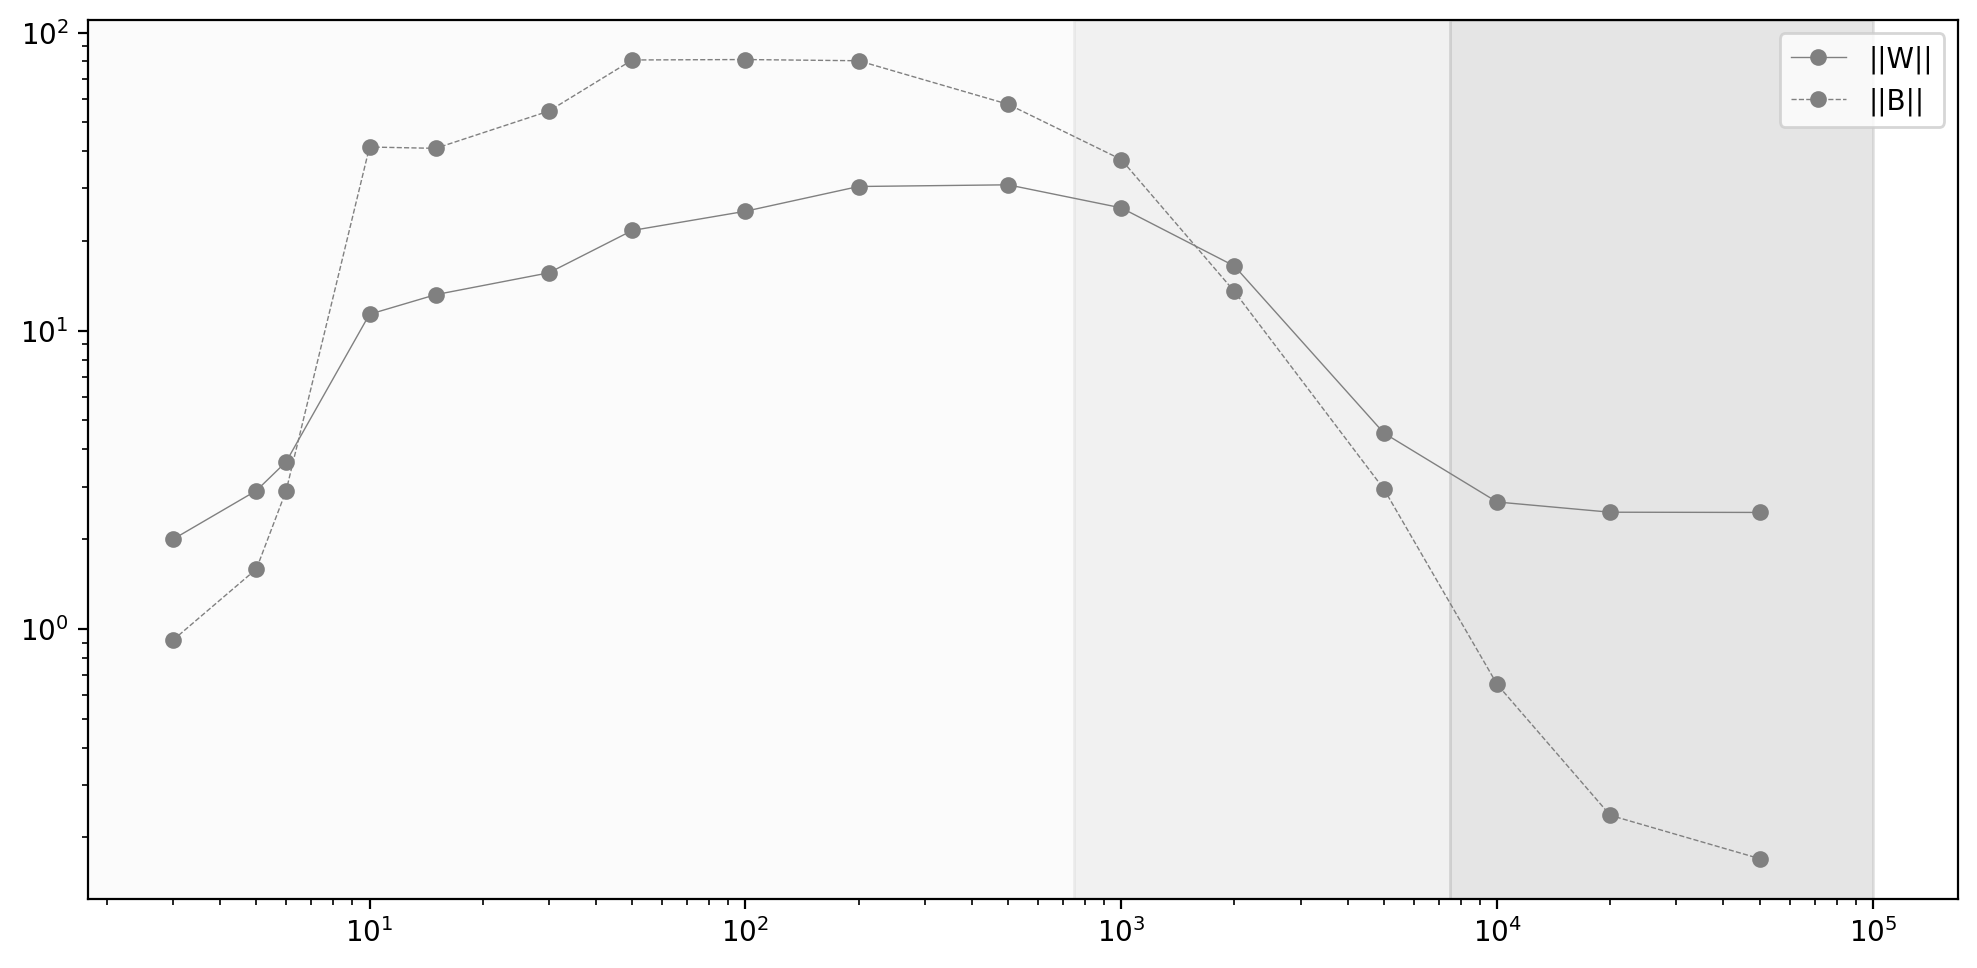

In [133]:


plt.figure(figsize=(10, 5))

plt.plot(T, w_norms, marker='o', markersize=5, label='||W||', linewidth=0.5, color='gray')
plt.plot(T, b_norms, marker='o', markersize=5, label='||B||', linestyle='--', linewidth=0.5, color='gray')

plt.axvspan(0, 750, color='whitesmoke', alpha=0.3)
plt.axvspan(750, 7500, color='lightgray', alpha=0.3)
plt.axvspan(7500, 100000, color='darkgray', alpha=0.3)

plt.yscale('log')
plt.xscale('log')

plt.tight_layout()
plt.legend()
plt.show()

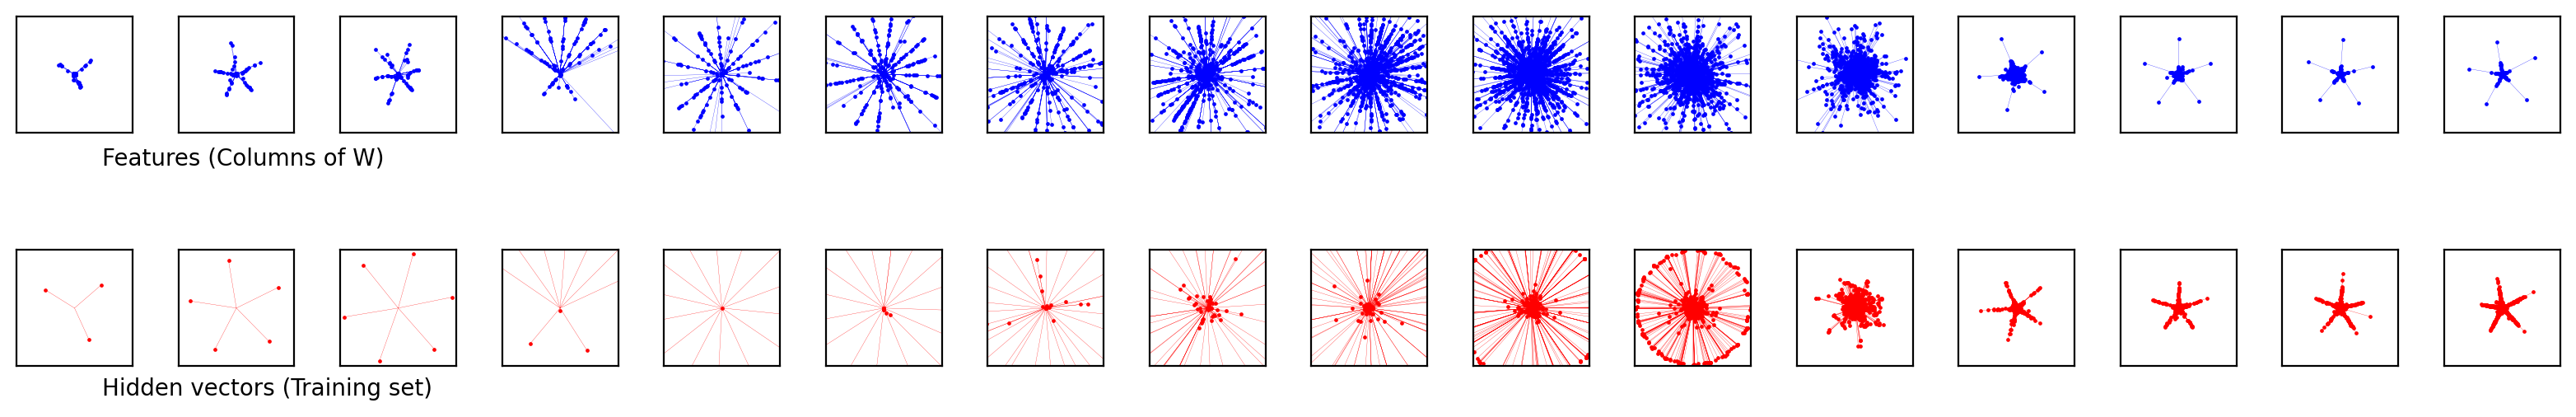

In [134]:
fig, _ = draw_mini_plots(T)

fig.text(0.05, 0.55, 'Features (Columns of W)', va='center', rotation='horizontal')
fig.text(0.05, 0.20, 'Hidden vectors (Training set)', va='center', rotation='horizontal')

plt.show()